# DIMACS CSP Instance Generator

Ce notebook permet de générer des instances CSP au format DIMACS avec différents types de contraintes.

## Types de contraintes supportés

1. **Inequality** : Variables doivent avoir des valeurs différentes
2. **Equality** : Variables doivent avoir les mêmes valeurs
3. **Sum Target** : Variables doivent avoir une somme spécifique
4. **Sum Even/Odd** : Variables doivent avoir une somme paire/impaire
5. **Greater Than** : Première variable doit être plus grande que la seconde
6. **Random** : Contraintes aléatoires

## Fonctions principales

- `generate_csp_instance()` : Fonction principale de génération paramétrable
- `generate_and_analyze()` : Génération avec analyse et visualisation
- `visualize_constraint_graph()` : Visualisation des graphes de contraintes
- `analyze_csp_instance()` : Analyse des propriétés des instances
- `generate_batch_instances()` : Génération par lots

## Utilisation

```python
# Générer une instance d'inégalité avec 5 variables, domaine de taille 3, 8 contraintes d'inégalité
generate_csp_instance("my_inequality", 5, 3, 8, "inequality")

# Générer une instance d'égalité
generate_csp_instance("my_equality", 4, 4, 6, "equality")

# Générer une instance de somme cible
generate_csp_instance("my_sum", 6, 3, 10, "sum_target", target=5)

# Générer une instance aléatoire
generate_csp_instance("my_random", 4, 3, 6, "random", density=0.7)
```


In [10]:
# Import des packages nécessaires
import random
import os
from typing import List, Tuple, Optional, Dict, Any

# Optional imports for visualization
try:
    import matplotlib.pyplot as plt
    import networkx as nx
    HAS_VISUALIZATION = True
except ImportError:
    HAS_VISUALIZATION = False
    print("Note: matplotlib et networkx non disponibles. Fonctionnalités de visualisation désactivées.")

## Fonctions de génération


In [11]:
def generate_csp_instance(name: str, num_variables: int, domain_size: int, num_constraints: int, 
                         constraint_type: str, target: int = 0, density: float = 0.5, 
                         output_dir: str = "instances", seed: Optional[int] = None) -> str:
    """
    Fonction principale de génération d'instances CSP au format DIMACS.
    
    Args:
        name: Nom de l'instance
        num_variables: Nombre de variables
        domain_size: Taille du domaine (valeurs de 1 à domain_size)
        num_constraints: Nombre de contraintes
        constraint_type: Type de contrainte ("inequality", "equality", "sum_target", "sum_even", "sum_odd", "greater_than", "random")
        target: Valeur cible pour les contraintes de somme (optionnel)
        density: Densité pour les contraintes aléatoires (optionnel)
        output_dir: Répertoire de sortie
        seed: Graine aléatoire pour la reproductibilité
    
    Returns:
        Chemin du fichier généré
    """
    
    if seed is not None:
        random.seed(seed)
    
    # Vérifier les paramètres
    if num_variables < 2:
        raise ValueError("Le nombre de variables doit être au moins 2")
    
    if domain_size < 1:
        raise ValueError("La taille du domaine doit être au moins 1")
    
    max_constraints = num_variables * (num_variables - 1) // 2
    if num_constraints > max_constraints:
        print(f"Attention: Réduction du nombre de contraintes de {num_constraints} à {max_constraints}")
        num_constraints = max_constraints
    
    # Générer les paires de variables pour les contraintes
    all_pairs = [(i, j) for i in range(num_variables) for j in range(i+1, num_variables)]
    selected_pairs = random.sample(all_pairs, num_constraints)
    
    # Générer les contraintes
    constraints = []
    
    for var1, var2 in selected_pairs:
        if constraint_type == "inequality":
            constraint = _generate_inequality_constraint(var1, var2, domain_size)
        elif constraint_type == "equality":
            constraint = _generate_equality_constraint(var1, var2, domain_size)
        elif constraint_type == "sum_target":
            if target == 0:
                target = 2 * domain_size  # Valeur par défaut
            constraint = _generate_sum_target_constraint(var1, var2, domain_size, target)
        elif constraint_type == "sum_even":
            constraint = _generate_sum_even_constraint(var1, var2, domain_size)
        elif constraint_type == "sum_odd":
            constraint = _generate_sum_odd_constraint(var1, var2, domain_size)
        elif constraint_type == "greater_than":
            constraint = _generate_greater_than_constraint(var1, var2, domain_size)
        elif constraint_type == "random":
            constraint = _generate_random_constraint(var1, var2, domain_size, density)
        else:
            raise ValueError(f"Type de contrainte non supporté: {constraint_type}")
        
        constraints.append(constraint)
    
    # Créer le contenu du fichier
    filename = f"{name}.csp"
    filepath = os.path.join(output_dir, filename)
    
    # Créer le répertoire s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)
    
    with open(filepath, "w") as file:
        # En-tête
        file.write(f"# CSP with {constraint_type} constraints\n")
        file.write(f"# Generated CSP instance\n")
        file.write(f"# Variables: {num_variables}, Domain size: {domain_size}\n")
        file.write(f"# Constraints: {num_constraints}\n\n")
        
        # Nombre de variables
        file.write(f"{num_variables}\n\n")
        
        # Domaines des variables
        file.write("# Variable domains (variable_id min_value max_value)\n")
        for i in range(num_variables):
            file.write(f"{i} 1 {domain_size}\n")
        file.write("\n")
        
        # Nombre de contraintes
        file.write(f"{num_constraints}\n\n")
        
        # Contraintes
        file.write("# Constraints (var1 var2 (value1,value2) (value3,value4) ...)\n")
        for var1, var2, pairs in constraints:
            if pairs:
                pair_strings = [f"({p[0]},{p[1]})" for p in pairs]
                file.write(f"{var1} {var2} {' '.join(pair_strings)}\n")
    
    print(f"Instance générée: {filepath}")
    print(f"Variables: {num_variables}")
    print(f"Domaine: 1 à {domain_size}")
    print(f"Contraintes: {num_constraints}")
    print(f"Type: {constraint_type}")
    
    return filepath

In [12]:
def _generate_inequality_constraint(var1: int, var2: int, domain_size: int) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte d'inégalité entre deux variables.
    """
    pairs = [(v1, v2) for v1 in range(1, domain_size + 1) 
             for v2 in range(1, domain_size + 1) if v1 != v2]
    return (var1, var2, pairs)

def _generate_equality_constraint(var1: int, var2: int, domain_size: int) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte d'égalité entre deux variables.
    """
    pairs = [(v, v) for v in range(1, domain_size + 1)]
    return (var1, var2, pairs)

def _generate_sum_target_constraint(var1: int, var2: int, domain_size: int, target: int) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte de somme cible entre deux variables.
    """
    pairs = [(v1, v2) for v1 in range(1, domain_size + 1) 
             for v2 in range(1, domain_size + 1) if v1 + v2 == target]
    return (var1, var2, pairs)

def _generate_sum_even_constraint(var1: int, var2: int, domain_size: int) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte de somme paire entre deux variables.
    """
    pairs = [(v1, v2) for v1 in range(1, domain_size + 1) 
             for v2 in range(1, domain_size + 1) if (v1 + v2) % 2 == 0]
    return (var1, var2, pairs)

def _generate_sum_odd_constraint(var1: int, var2: int, domain_size: int) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte de somme impaire entre deux variables.
    """
    pairs = [(v1, v2) for v1 in range(1, domain_size + 1) 
             for v2 in range(1, domain_size + 1) if (v1 + v2) % 2 == 1]
    return (var1, var2, pairs)

def _generate_greater_than_constraint(var1: int, var2: int, domain_size: int) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte où la première variable doit être plus grande que la seconde.
    """
    pairs = [(v1, v2) for v1 in range(1, domain_size + 1) 
             for v2 in range(1, domain_size + 1) if v1 > v2]
    return (var1, var2, pairs)

def _generate_random_constraint(var1: int, var2: int, domain_size: int, density: float = 0.5) -> Tuple[int, int, List[Tuple[int, int]]]:
    """
    Génère une contrainte aléatoire entre deux variables.
    """
    all_pairs = [(v1, v2) for v1 in range(1, domain_size + 1) 
                 for v2 in range(1, domain_size + 1)]
    num_pairs = max(1, int(round(len(all_pairs) * density)))
    pairs = random.sample(all_pairs, num_pairs)
    return (var1, var2, pairs)


## Exemples d'utilisation


In [13]:
def visualize_constraint_graph(constraints: List[Tuple[int, int, List[Tuple[int, int]]]], 
                              num_variables: int, title: str = "Graphe de contraintes CSP"):
    """
    Visualise le graphe de contraintes d'une instance CSP.
    
    Args:
        constraints: Liste des contraintes (var1, var2, pairs)
        num_variables: Nombre de variables
        title: Titre du graphe
    """
    if not HAS_VISUALIZATION:
        print("Visualisation non disponible. Installez matplotlib et networkx pour activer cette fonctionnalité.")
        return
    
    G = nx.Graph()
    G.add_nodes_from(range(num_variables))
    
    for var1, var2, _ in constraints:
        G.add_edge(var1, var2)
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=1000, font_size=16, font_weight='bold')
    plt.title(f"{title}\n{num_variables} variables, {len(constraints)} contraintes")
    plt.show()

def analyze_csp_instance(constraints: List[Tuple[int, int, List[Tuple[int, int]]]], 
                        num_variables: int, domain_size: int) -> Dict[str, Any]:
    """
    Analyse les propriétés d'une instance CSP générée.
    
    Args:
        constraints: Liste des contraintes
        num_variables: Nombre de variables
        domain_size: Taille du domaine
    
    Returns:
        Dictionnaire contenant les métriques d'analyse
    """
    total_possible_assignments = domain_size ** num_variables
    
    # Calculer la densité des contraintes
    max_possible_constraints = num_variables * (num_variables - 1) // 2
    actual_density = len(constraints) / max_possible_constraints if max_possible_constraints > 0 else 0
    
    # Calculer la serrage moyen des contraintes
    total_possible_pairs = domain_size ** 2
    avg_allowed_pairs = sum(len(pairs) for _, _, pairs in constraints) / len(constraints) if constraints else 0
    avg_tightness = 1 - (avg_allowed_pairs / total_possible_pairs)
    
    analysis = {
        'num_variables': num_variables,
        'domain_size': domain_size,
        'num_constraints': len(constraints),
        'total_possible_assignments': total_possible_assignments,
        'constraint_density': actual_density,
        'avg_constraint_tightness': avg_tightness,
        'avg_allowed_pairs_per_constraint': avg_allowed_pairs
    }
    
    print("Analyse de l'instance CSP:")
    print(f"  Variables: {num_variables}")
    print(f"  Taille du domaine: {domain_size}")
    print(f"  Contraintes: {len(constraints)}")
    print(f"  Assignations possibles totales: {total_possible_assignments}")
    print(f"  Densité des contraintes: {actual_density:.3f}")
    print(f"  Serrage moyen des contraintes: {avg_tightness:.3f}")
    print(f"  Paires autorisées moyennes par contrainte: {avg_allowed_pairs:.1f}")
    
    return analysis

def generate_and_analyze(name: str, num_variables: int, domain_size: int, num_constraints: int,
                        constraint_type: str, target: int = 0, density: float = 0.5, 
                        output_dir: str = "instances", seed: Optional[int] = None, 
                        visualize: bool = True) -> Tuple[str, Dict[str, Any]]:
    """
    Génère une instance CSP, l'analyse et la visualise.
    
    Args:
        name: Nom de l'instance
        num_variables: Nombre de variables
        domain_size: Taille du domaine
        num_constraints: Nombre de contraintes
        constraint_type: Type de contrainte
        target: Valeur cible pour les contraintes de somme
        density: Densité pour les contraintes aléatoires
        output_dir: Répertoire de sortie
        seed: Graine aléatoire
        visualize: Si True, affiche le graphe de contraintes
    
    Returns:
        Tuple (chemin_fichier, analyse)
    """
    # Générer l'instance
    filepath = generate_csp_instance(name, num_variables, domain_size, num_constraints,
                                   constraint_type, target, density, output_dir, seed)
    
    # Reconstruire les contraintes pour l'analyse
    if seed is not None:
        random.seed(seed)
    
    all_pairs = [(i, j) for i in range(num_variables) for j in range(i+1, num_variables)]
    selected_pairs = random.sample(all_pairs, num_constraints)
    
    constraints = []
    for var1, var2 in selected_pairs:
        if constraint_type == "inequality":
            constraint = _generate_inequality_constraint(var1, var2, domain_size)
        elif constraint_type == "equality":
            constraint = _generate_equality_constraint(var1, var2, domain_size)
        elif constraint_type == "sum_target":
            if target == 0:
                target = 2 * domain_size
            constraint = _generate_sum_target_constraint(var1, var2, domain_size, target)
        elif constraint_type == "sum_even":
            constraint = _generate_sum_even_constraint(var1, var2, domain_size)
        elif constraint_type == "sum_odd":
            constraint = _generate_sum_odd_constraint(var1, var2, domain_size)
        elif constraint_type == "greater_than":
            constraint = _generate_greater_than_constraint(var1, var2, domain_size)
        elif constraint_type == "random":
            constraint = _generate_random_constraint(var1, var2, domain_size, density)
        constraints.append(constraint)
    
    # Analyser l'instance
    analysis = analyze_csp_instance(constraints, num_variables, domain_size)
    
    # Visualiser si demandé
    if visualize:
        visualize_constraint_graph(constraints, num_variables, f"Instance {name}")
    
    return filepath, analysis


# CSP Instance Generator

This notebook provides tools to generate Constraint Satisfaction Problem (CSP) instances with various parameters and constraint types.

## Features
- Generate random CSP instances with configurable parameters
- Support for different constraint types (equality, inequality, arithmetic, etc.)
- Export instances in the standard CSP format
- Visualize constraint graphs
- Analyze instance difficulty and properties

## Usage

The generator supports comments in CSP files (lines starting with #) and can create instances with various parameters.


### Generate a simple instance:
```python
generator = CSPGenerator(4, 3, 4, 0.4, seed=42)
generator.generate_constraints()
generator.export_to_file("my_instance.csp")
```

### Generate with specific constraints:
```python
generator = CSPGenerator(5, 4, 6, seed=42)
generator.generate_specific_constraint_type("equality")
generator.export_to_file("equality_instance.csp")
```



=== Exemple 1: Instance d'inégalité ===
Instance générée: instances/example_inequality.csp
Variables: 4
Domaine: 1 à 3
Contraintes: 6
Type: inequality
Analyse de l'instance CSP:
  Variables: 4
  Taille du domaine: 3
  Contraintes: 6
  Assignations possibles totales: 81
  Densité des contraintes: 1.000
  Serrage moyen des contraintes: 0.333
  Paires autorisées moyennes par contrainte: 6.0


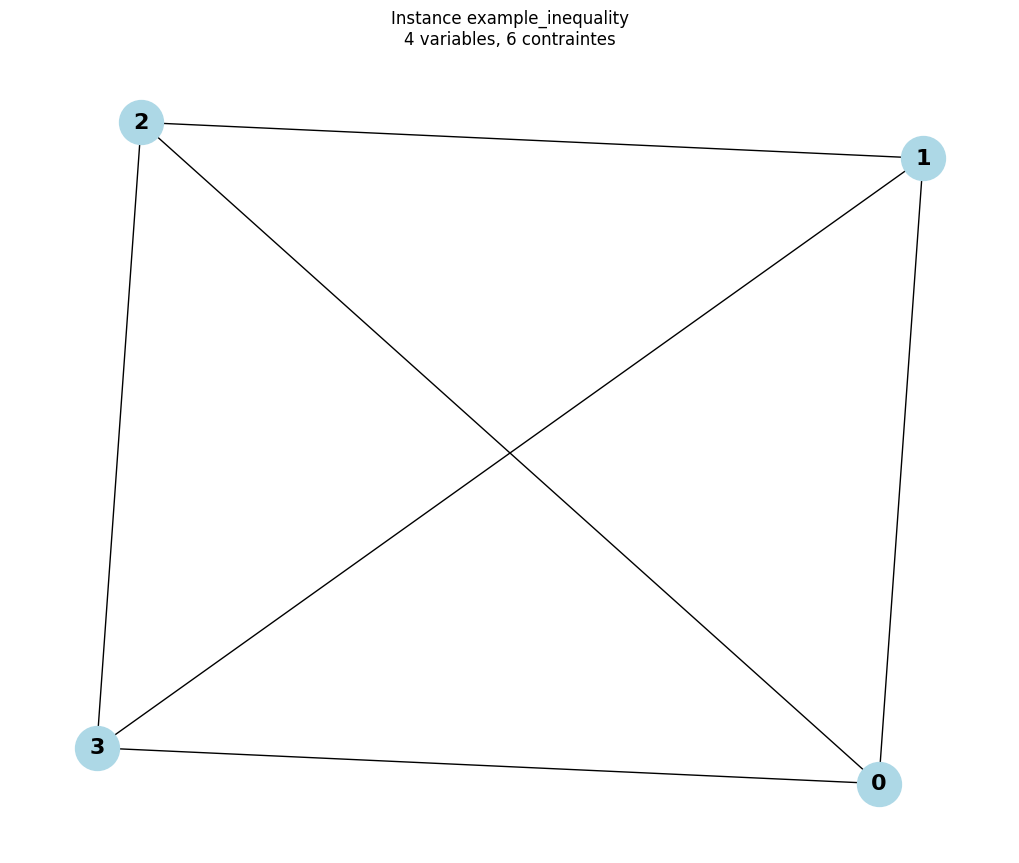

In [14]:
# Exemple 1: Instance d'inégalité simple
print("=== Exemple 1: Instance d'inégalité ===")
filepath, analysis = generate_and_analyze("example_inequality", 4, 3, 6, "inequality", seed=42)

## CSP Instance Generator Class



=== Exemple 3: Instance de somme cible ===


Instance générée: instances/example_sum.csp
Variables: 4
Domaine: 1 à 3
Contraintes: 6
Type: sum_target
Analyse de l'instance CSP:
  Variables: 4
  Taille du domaine: 3
  Contraintes: 6
  Assignations possibles totales: 81
  Densité des contraintes: 1.000
  Serrage moyen des contraintes: 0.778
  Paires autorisées moyennes par contrainte: 2.0


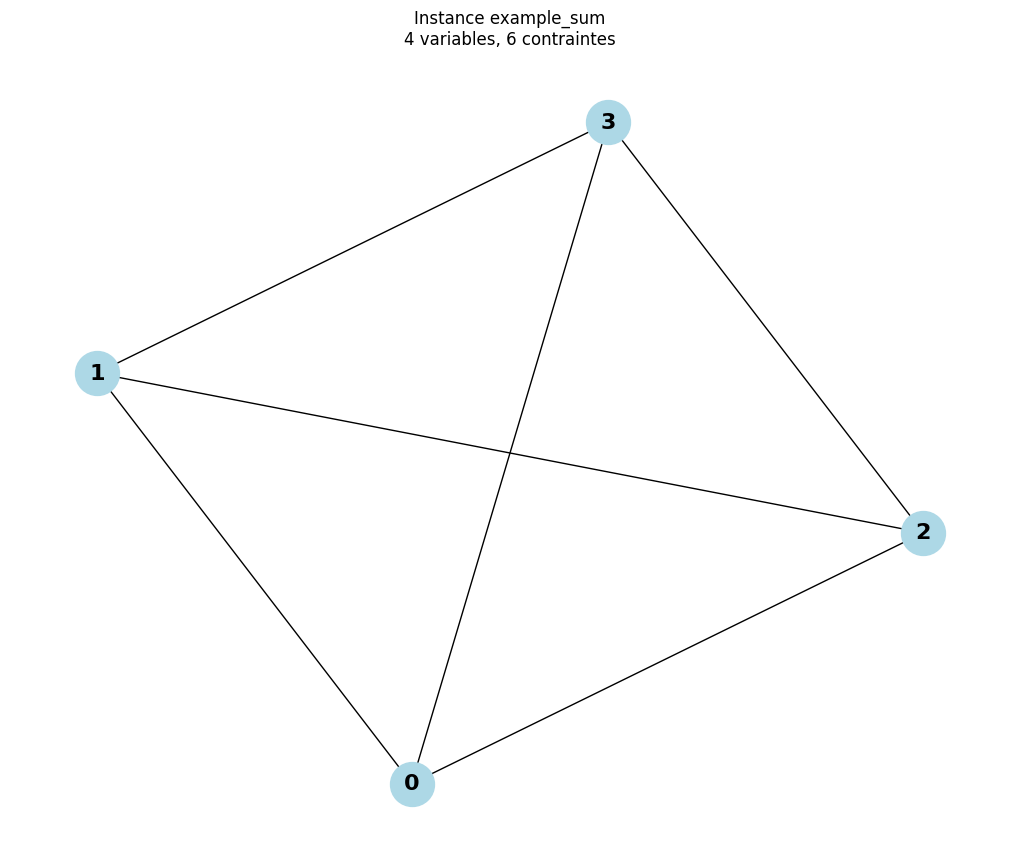

In [15]:
# Exemple 3: Instance de somme cible
print("\n=== Exemple 3: Instance de somme cible ===")
filepath, analysis = generate_and_analyze("example_sum", 4, 3, 6, "sum_target", target=5, seed=42)


=== Exemple 4: Instance aléatoire ===
Instance générée: instances/example_random.csp
Variables: 4
Domaine: 1 à 3
Contraintes: 6
Type: random
Analyse de l'instance CSP:
  Variables: 4
  Taille du domaine: 3
  Contraintes: 6
  Assignations possibles totales: 81
  Densité des contraintes: 1.000
  Serrage moyen des contraintes: 0.333
  Paires autorisées moyennes par contrainte: 6.0


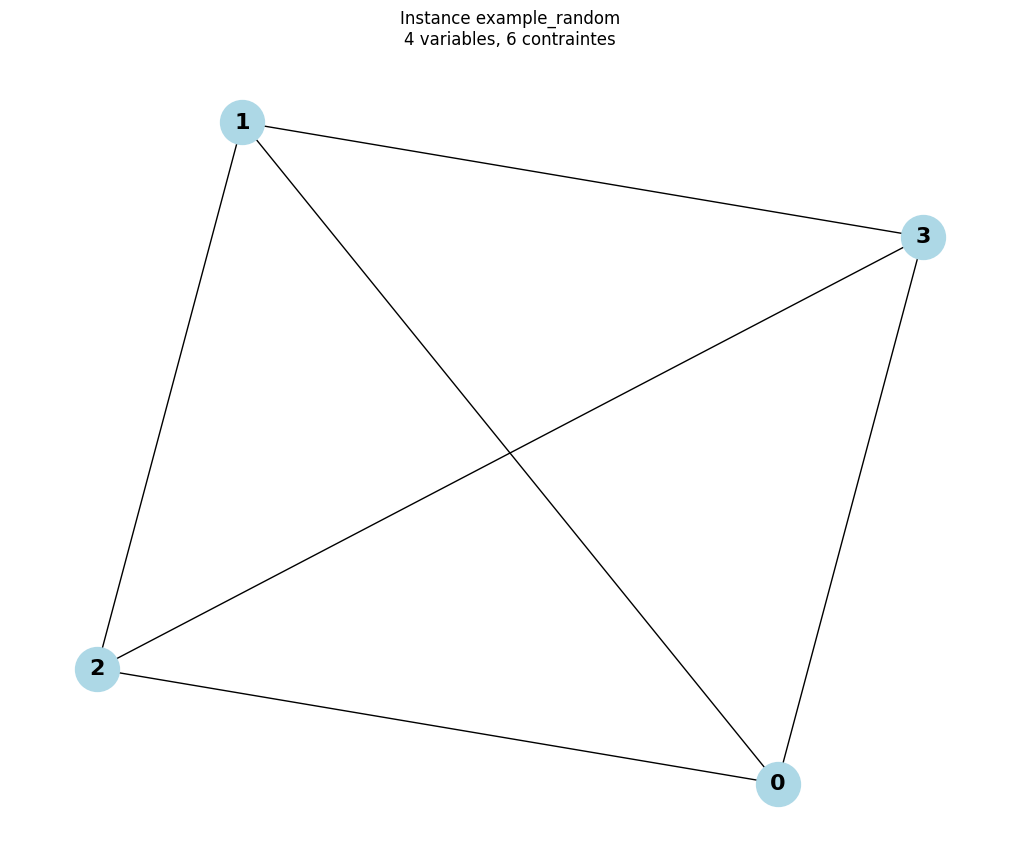

In [16]:
# Exemple 4: Instance aléatoire
print("\n=== Exemple 4: Instance aléatoire ===")
filepath, analysis = generate_and_analyze("example_random", 4, 3, 6, "random", density=0.7, seed=42)

## Generate Random Instances


In [17]:
def generate_batch_instances():
    """Génère un lot d'instances avec différents paramètres."""
    
    # Petites instances (pour les tests)
    small_configs = [
        (3, 3, 2, 0.5, "small_sparse"),
        (3, 3, 3, 0.3, "small_dense"),
        (4, 3, 4, 0.4, "small_medium")
    ]
    
    # Instances moyennes
    medium_configs = [
        (5, 4, 6, 0.3, "medium_sparse"),
        (5, 4, 8, 0.5, "medium_dense"),
        (6, 3, 8, 0.4, "medium_medium")
    ]
    
    # Grandes instances (pour les tests de performance)
    large_configs = [
        (8, 4, 12, 0.3, "large_sparse"),
        (8, 4, 16, 0.4, "large_dense"),
        (10, 3, 15, 0.3, "large_very_sparse")
    ]
    
    all_configs = small_configs + medium_configs + large_configs
    
    for num_vars, domain_size, num_constraints, density, name in all_configs:
        print(f"\nGénération de {name}...")
        
        filepath, analysis = generate_and_analyze(
            name, num_vars, domain_size, num_constraints, 
            "random", density=density, output_dir="instances", 
            seed=42, visualize=False
        )
        
        print(f"Fichier généré: {filepath}")

# Exécuter la génération par lots
generate_batch_instances()


Génération de small_sparse...
Instance générée: instances/small_sparse.csp
Variables: 3
Domaine: 1 à 3
Contraintes: 2
Type: random
Analyse de l'instance CSP:
  Variables: 3
  Taille du domaine: 3
  Contraintes: 2
  Assignations possibles totales: 27
  Densité des contraintes: 0.667
  Serrage moyen des contraintes: 0.556
  Paires autorisées moyennes par contrainte: 4.0
Fichier généré: instances/small_sparse.csp

Génération de small_dense...
Instance générée: instances/small_dense.csp
Variables: 3
Domaine: 1 à 3
Contraintes: 3
Type: random
Analyse de l'instance CSP:
  Variables: 3
  Taille du domaine: 3
  Contraintes: 3
  Assignations possibles totales: 27
  Densité des contraintes: 1.000
  Serrage moyen des contraintes: 0.667
  Paires autorisées moyennes par contrainte: 3.0
Fichier généré: instances/small_dense.csp

Génération de small_medium...
Instance générée: instances/small_medium.csp
Variables: 4
Domaine: 1 à 3
Contraintes: 4
Type: random
Analyse de l'instance CSP:
  Variables: 4

## Generate Specific Constraint Types


In [18]:
# Générer des instances avec différents types de contraintes
constraint_types = ["equality", "inequality", "sum_even", "sum_odd", "greater_than", "sum_target"]

for constraint_type in constraint_types:
    print(f"\nGénération de contraintes {constraint_type}...")
    
    filepath, analysis = generate_and_analyze(
        f"{constraint_type}_example", 4, 3, 4, constraint_type, 
        target=5 if constraint_type == "sum_target" else 0,
        output_dir="instances", seed=42, visualize=False
    )
    
    print(f"Fichier généré: {filepath}")


Génération de contraintes equality...
Instance générée: instances/equality_example.csp
Variables: 4
Domaine: 1 à 3
Contraintes: 4
Type: equality
Analyse de l'instance CSP:
  Variables: 4
  Taille du domaine: 3
  Contraintes: 4
  Assignations possibles totales: 81
  Densité des contraintes: 0.667
  Serrage moyen des contraintes: 0.667
  Paires autorisées moyennes par contrainte: 3.0
Fichier généré: instances/equality_example.csp

Génération de contraintes inequality...
Instance générée: instances/inequality_example.csp
Variables: 4
Domaine: 1 à 3
Contraintes: 4
Type: inequality
Analyse de l'instance CSP:
  Variables: 4
  Taille du domaine: 3
  Contraintes: 4
  Assignations possibles totales: 81
  Densité des contraintes: 0.667
  Serrage moyen des contraintes: 0.333
  Paires autorisées moyennes par contrainte: 6.0
Fichier généré: instances/inequality_example.csp

Génération de contraintes sum_even...
Instance générée: instances/sum_even_example.csp
Variables: 4
Domaine: 1 à 3
Contrainte